In [105]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input,Flatten, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from tensorflow.keras.layers import Dense
from keras import backend as k
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [109]:
# load dataset
# (trainX, trainY), (testX, testY) = mnist.load_data()
(train_x,train_y), (test_x, test_y)=mnist.load_data()

In [110]:
#Normalize data to convert from 2D to 1D
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x = train_x / 255
test_x = test_x / 255

In [111]:
# reshape dataset to have a single channel
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))
input_shape = (28, 28, 1)


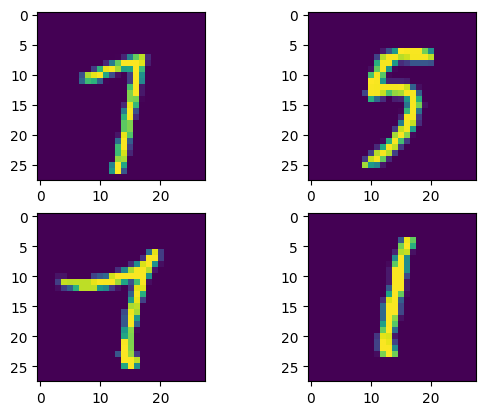

In [112]:
#View a few images
plt.figure(1)
plt.subplot(221)
plt.imshow(train_x[42][:,:,0])

plt.subplot(222)
plt.imshow(train_x[420][:,:,0])

plt.subplot(223)
plt.imshow(train_x[4200][:,:,0])

plt.subplot(224)
plt.imshow(train_x[42000][:,:,0])
plt.show()

In [113]:
# build the model then encoder before define 4 Conv2D,flatten, and then dense

latent_dim= 2 
# Define Encoder and add convolutional layers 
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
#Shape of conv to be provided to decoder
conv_shape = k.int_shape(x)
#Flatten
x=Flatten()(x)
x= Dense(32, activation='relu')(x)

# Two outputs, for latent mean and log variance (std. dev.)
 #Mean values of encoded input
z_mu = Dense(latent_dim, name='latent_mu')(x)
#Std dev. (variance) of encoded input  
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  


In [114]:
#REPARAMETERIZATION TRICK
#z=mu +sigma times ebslon(ebslon is normal distribution)
def sample_z(args):
  z_mu, z_sigma = args
  eps = k.random_normal(shape=(k.shape(z_mu)[0], k.int_shape(z_mu)[1]))
  return z_mu + k.exp(z_sigma / 2) * eps

In [115]:
# sample vector from the latent distribution
# z is the labda custom layer we are adding for gradient descent calculations using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

In [116]:
#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 64)   18496       ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 64)   36928       ['conv2d_33[0][0]']              
                                                                                            

In [117]:
# Decoder
# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
# add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

In [118]:
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)

In [119]:
#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = Conv2DTranspose(1, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

In [120]:
# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 12544)             37632     
                                                                 
 reshape_3 (Reshape)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289       
 pose)                                                           
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable

Define custom loss
VAE is trained using two loss functions reconstruction loss and KL divergence
Let us add a class to define a custom layer with loss

In [121]:
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = k.flatten(x)
        z_decoded = k.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * k.mean(1 + z_sigma - k.square(z_mu) - k.exp(z_sigma), axis=-1)
        return k.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
# apply the custom loss to the input images and the decoded latent distribution sample y is original image after encoding input img to mu, sigma, z
y = CustomLayer()([input_img, z_decoded])


In [122]:
# VAE 

vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss = None)
vae.summary()

# Train autoencoder
vae.fit(train_x, None, epochs = 5, batch_size = 32, validation_split = 0.2)



Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 64)   18496       ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 64)   36928       ['conv2d_33[0][0]']              
                                                                                                

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 224s 5ms/sample - loss: 0.2256 - val_loss: 0.2036
Epoch 2/5
48000/48000 [==============================] - 224s 5ms/sample - loss: 0.1993 - val_loss: 0.1939
Epoch 3/5
48000/48000 [==============================] - 224s 5ms/sample - loss: 0.1930 - val_loss: 0.1903
Epoch 4/5
48000/48000 [==============================] - 230s 5ms/sample - loss: 0.1897 - val_loss: 0.1879
Epoch 5/5
48000/48000 [==============================] - 239s 5ms/sample - loss: 0.1876 - val_loss: 0.1863


/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


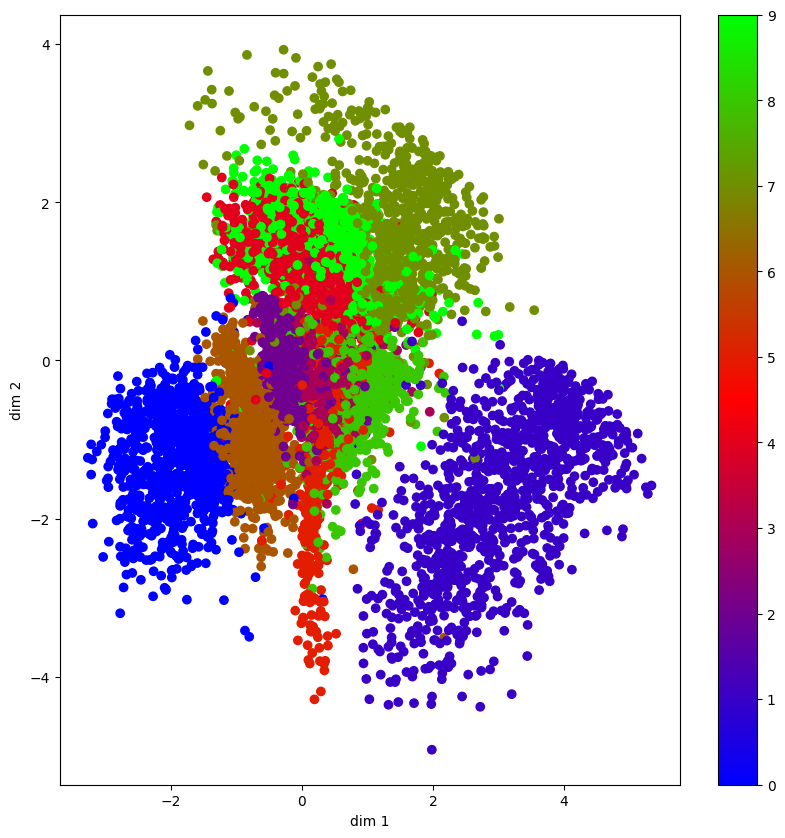

In [123]:
mu, _, _ = encoder.predict(test_x)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=test_y, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

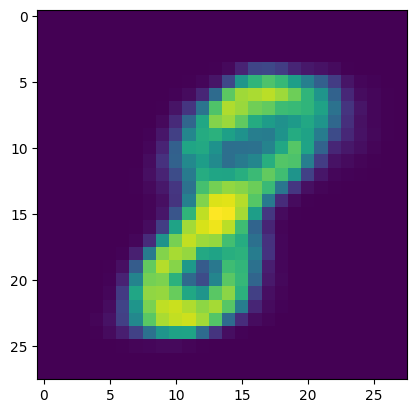

In [124]:
sample_vector = np.array([[1,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

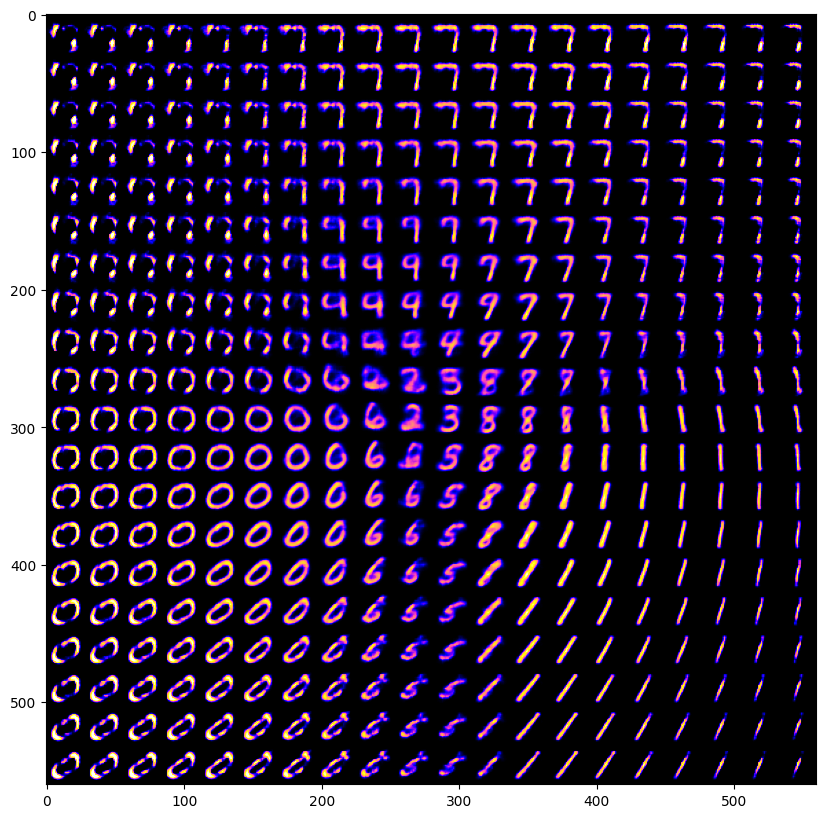

In [125]:
# generate 15x15 digits
n = 20   
figure = np.zeros((img_width * n, img_height * n, num_channels))
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  